In [31]:
import sys,os

#sys.path.append('/home/arash/VRdataCleaning/DeepSurv/')

import importlib
import deepsurv
from statsmodels.stats.outliers_influence import variance_inflation_factor    
import argparse
import uuid
import pickle
import json
import time
import numpy as np
import pandas as pd

import lasagne
import optunity

import logging
from logging import handlers
from sklearn.model_selection import train_test_split

importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
from eli5.permutation_importance import get_score_importances
import shap  # package used to calculate Shap values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Load data: 
#### xtrain: 80% of all data, devided into xtrainsub & xvalsub (80 and 20%) 
#### xtest: 20% of all data

In [3]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrain', 'rb') as f:
    ytrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'rb') as f:
    xtest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytest', 'rb') as f:
    ytest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrainsub', 'rb') as f:
    xtrainsub=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrainsub', 'rb') as f:
    ytrainsub=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xvalsub', 'rb') as f:
    xvalsub=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/yvalsub', 'rb') as f:
    yvalsub=pickle.load(f) 

In [4]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:
    NCtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:
    NCtest=pickle.load(f) 

In [5]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:
    NCtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:
    NCtest=pickle.load(f) 

In [6]:
def load_logger(logdir):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    
    # Print to Stdout
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(format)
    logger.addHandler(ch)

    # Print to Log file
    fh = logging.FileHandler(os.path.join(logdir, 'log_' + str(uuid.uuid4())))
    fh.setFormatter(format)
    logger.addHandler(fh)

    return logger

def format_to_deepsurv(x, y):
    return {
        'x': x,
        'e': y[:,0].astype(np.int32),
        't': y[:,1].astype(np.float32)
    }

In [7]:
def load_box_constraints(file):
    with open(file, 'rb') as fp:
        return json.loads(fp.read())

In [41]:
def save_call_log(file, call_log):
    with open(file, 'wb') as fp:
        pickle.dump(call_log, fp)

def get_objective_function(num_epochs, logdir, update_fn = lasagne.updates.adam):
    '''
    Returns the function for Optunity to optimize. The function returned by get_objective_function
    takes the parameters: x_train, y_train, x_test, and y_test, and any additional kwargs to 
    use as hyper-parameters.

    The objective function runs a DeepSurv model on the training data and evaluates it against the
    a validation set. The result of the function call is the validation concordance index 
    (which Optunity tries to optimize)
    '''
    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(x,params):
        hyperparams = {
            'batch_norm': True,
            'activation': 'rectify',
            'standardize': False
        }

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']

        if 'learning_rate' in params:
            params['learning_rate'] = 10 ** params['learning_rate']
        
        if 'n_in' in params:
            params['n_in']= int(np.floor(params['n_in']))
        
            
            

        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train,y_train,x_test,y_test,
        **kwargs):
        hyperparams = get_hyperparams(x_train,kwargs)
        x_train=x_train[:,0:hyperparams['n_in']]
        x_test=x_test[:,0:hyperparams['n_in']]
     
        
        # Standardize the datasets
        #train_mean = x_train.mean(axis = 0)
        #train_std = x_train.std(axis = 0)

        #x_train = (x_train - train_mean) / train_std
        #x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        

        # Set up Tensorboard loggers
        model_id = str(hash(str(hyperparams)))
        run_id = model_id + '_' + str(uuid.uuid4())
        logger = TensorboardLogger('hyperparam_search', 
            os.path.join(logdir,"tensor_logs", model_id, run_id))

        network = deep_surv.DeepSurv(**hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs, logger=logger, 
            update_fn = update_fn, verbose = False)

        result = network.get_concordance_index(**valid_data)
        main_logger.info('Run id: %s | %s | C-Index: %f | Train Loss %f' % (run_id, str(hyperparams), result, metrics['loss'][-1][1]))
        return result

    return train_deepsurv


## Find the optimal hyper-parameters using training data and save them in opt_params


In [42]:
NUM_EPOCHS = 200
NUM_FOLDS = 8
logdir='/home/arash/ProjectVR/logs'


In [43]:
main_logger = load_logger(logdir)


#    main_logger.debug('Loading dataset: ' + args.dataset)
box_constraints = load_box_constraints('/home/arash/ProjectVR/box_constraints.0.json')

In [ ]:
opt_fxn = get_objective_function(NUM_EPOCHS, logdir, 
                                 utils.get_optimizer_from_str('adam'))

opt_fxn = optunity.cross_validated(x=xtrain, y=ytrain, num_folds=NUM_FOLDS)(opt_fxn)


opt_params, call_log, _ = optunity.maximize(opt_fxn, num_evals=80,
        solver_name='sobol',
        **box_constraints)

2019-11-12 12:32:09,802 - __main__ - INFO - Run id: 2454451898833283779_a3ac367f-94ac-456c-8149-56aa339df76e | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00015485351562500002, 'learning_rate': 1.2493372456577218e-05, 'dropout': 0.18027734375, 'n_in': 17, 'hidden_layers_sizes': [82]} | C-Index: 0.523943 | Train Loss 15.311080
2019-11-12 12:32:09,802 - __main__ - INFO - Run id: 2454451898833283779_a3ac367f-94ac-456c-8149-56aa339df76e | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00015485351562500002, 'learning_rate': 1.2493372456577218e-05, 'dropout': 0.18027734375, 'n_in': 17, 'hidden_layers_sizes': [82]} | C-Index: 0.523943 | Train Loss 15.311080
2019-11-12 12:32:09,802 - __main__ - INFO - Run id: 2454451898833283779_a3ac367f-94ac-456c-8149-56aa339df76e | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00015485351562500002, 'learning_rate': 1.2493372456577218e-05, 'dropout': 0

2019-11-12 12:33:54,376 - __main__ - INFO - Run id: 2454451898833283779_3e1be96f-5f58-43b6-bc76-175fa9528edb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00015485351562500002, 'learning_rate': 1.2493372456577218e-05, 'dropout': 0.18027734375, 'n_in': 17, 'hidden_layers_sizes': [82]} | C-Index: 0.547034 | Train Loss 17.080440
2019-11-12 12:33:54,376 - __main__ - INFO - Run id: 2454451898833283779_3e1be96f-5f58-43b6-bc76-175fa9528edb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00015485351562500002, 'learning_rate': 1.2493372456577218e-05, 'dropout': 0.18027734375, 'n_in': 17, 'hidden_layers_sizes': [82]} | C-Index: 0.547034 | Train Loss 17.080440
2019-11-12 12:34:20,519 - __main__ - INFO - Run id: 2454451898833283779_d01bc37b-93d1-4df7-abaf-e1d01c4e7fce | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00015485351562500002, 'learning_rate': 1.2493372456577218e-05, 'dropout': 0

In [29]:
opt_params

{'lr_decay': 0.0004941992187500001,
 'learning_rate': -3.0432031250000002,
 'num_nodes': 89.2826171875,
 'num_layers': 2.0997460937500003,
 'momentum': 0.8704228515624999,
 'L2_reg': 3.8745517578124997,
 'dropout': 0.23171093750000002,
 'n_in': 19.4337337890625}

## train a network based on opt_params on training data and save the model and weights (previous sections used cross-validation to find hyper-parameters, weights could not be saved)

In [36]:
NUM_EPOCHS=200
hyperparams = {
    'batch_norm': True,
    'activation': 'rectify',
    'standardize': False
}

hyperparams.update(opt_params)

if 'num_layers' in hyperparams and 'num_nodes' in hyperparams:
    hyperparams['hidden_layers_sizes'] = [int(hyperparams['num_nodes'])] * int(hyperparams['num_layers'])
    del hyperparams['num_layers']
    del hyperparams['num_nodes']

if 'learning_rate' in hyperparams:
    hyperparams['learning_rate'] = 10 ** hyperparams['learning_rate']
       
if 'n_in' in hyperparams:
    hyperparams['n_in']= int(np.floor(hyperparams['n_in']))

In [37]:
### Standardizing
#trainsub_mean = xtrainsub.mean(axis = 0)
#trainsub_std = xtrainsub.std(axis = 0)
#xtrainsub = (xtrainsub - trainsub_mean) / trainsub_std

trainsub_data=format_to_deepsurv(xtrainsub, ytrainsub)
trainsub_data['x']=trainsub_data['x'][:,0:hyperparams['n_in']]
#valsub_mean = xvalsub.mean(axis = 0)
#valsub_std = xvalsub.std(axis = 0)
#xvalsub = (xvalsub - valsub_mean) / valsub_std

valsub_data=format_to_deepsurv(xvalsub, yvalsub)
valsub_data['x']=valsub_data['x'][:,0:hyperparams['n_in']]

network = deep_surv.DeepSurv(**hyperparams)

In [38]:
metrics = network.train(trainsub_data,valsub_data, n_epochs = NUM_EPOCHS, update_fn = lasagne.updates.adam, verbose = True)

In [39]:
network.get_concordance_index(xtest[:,0:hyperparams['n_in']],ytest[:,1],ytest[:,0])

0.556253484303812

In [48]:
trainsub_data['x'].shape

(1465, 42)

## apply the trained network on test set and check the feature importance for generalization using  [permutation importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)


In [ ]:
colnames=test.iloc[:,1:-1].columns
def score(X, y):
    X=pd.DataFrame(X)
    X.columns=colnames
    data=X
    data['Wait Time (s)']=y.values
    data['E']=1
    test = dataframe_to_deepsurv_ds(data, event_col = 'E', time_col= 'Wait Time (s)')
    xtest=test['x']
    xtest = (xtest - trainsub_mean) / trainsub_std              
    etest=test['e']
    ttest=test['t']
    ytest = np.column_stack((etest, ttest))
    valid_data = format_to_deepsurv(xtest, ytest)               #fix: network is trained again on test data
    ci=network.get_concordance_index(**valid_data)
    return ci


st=time.time()

base_score, score_decreases = get_score_importances(score, test.iloc[:,1:-1].values, test.iloc[:,0])
                                                    #,columns_to_shuffle=range(0,2))
f=time.time()

feature_importances_mean = np.mean(score_decreases, axis=0)
feature_importances_std = np.std(score_decreases, axis=0)

perimportance=pd.DataFrame(data=feature_importances_mean,index=colnames,columns=['mean'])
perimportance['std']=feature_importances_std



perimportance=perimportance.sort_values(by=['mean'])



def plot_feature_importances(imp):
    plt.figure(figsize=(16,12))
    n_features = imp.shape[0]
    plt.barh(range(n_features), perimportance.iloc[:,0].values, align='center')
    plt.yticks(np.arange(n_features), colnames)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(perimportance)
#plt.savefig('Decision Tree feature_importance')

In [ ]:
NCtrain.iloc[:,1:-1].columns

In [216]:
NCtrain.iloc[:,0:hyperparams['n_in']].columns

Index(['Mean Arrival Rate_1100.0', 'numcars_morethan1', 'Speed Limit_30.0',
       'shopwalk_No', 'mode_Car', 'over50', 'workwalk_Yes', 'Snowy',
       'shopwalk_Yes', 'Age_18 - 24', 'mode_Walking', 'Gender_Female',
       'Lane Width_3.0', 'One way', 'mode_Public Transit', 'Vrexp_Yes',
       'driving license_Yes', 'Mixed', 'Age_25 - 29', 'Minimum Gap_2.0'],
      dtype='object')

## Using Shap for feature importance

In [217]:
#using train set for interpretability
dfxtrainsub=pd.DataFrame(xtrain[:,0:hyperparams['n_in']])
dfxtrainsub.columns=NCtrain.iloc[:,0:hyperparams['n_in']].columns

#using zeros as background data
backgrounddata=pd.DataFrame(np.zeros(hyperparams['n_in'])).T         
backgrounddata.columns=NCtrain.iloc[:,0:hyperparams['n_in']].columns

explainer = shap.KernelExplainer(network.predict_risk,backgrounddata)
shap_values = explainer.shap_values(dfxtrainsub)

  0%|          | 0/1832 [00:00<?, ?it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  0%|          | 1/1832 [00:00<03:46,  8.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  0%|          | 2/1832 [00:00<04:05,  7.44it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.2

  1%|          | 21/1832 [00:03<05:05,  5.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  1%|          | 22/1832 [00:03<05:05,  5.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  1%|▏         | 23/1832 [00:03<05:17,  5.70it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  2%|▏         | 42/1832 [00:07<06:28,  4.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  2%|▏         | 43/1832 [00:07<05:56,  5.02it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  2%|▏         | 44/1832 [00:07<06:06,  4.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  3%|▎         | 63/1832 [00:11<05:00,  5.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  3%|▎         | 64/1832 [00:11<04:57,  5.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  4%|▎         | 65/1832 [00:11<04:49,  6.10it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  5%|▍         | 84/1832 [00:14<05:07,  5.69it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  5%|▍         | 85/1832 [00:15<06:28,  4.50it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  5%|▍         | 86/1832 [00:15<06:03,  4.80it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  6%|▌         | 105/1832 [00:18<05:29,  5.23it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  6%|▌         | 106/1832 [00:19<05:29,  5.24it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  6%|▌         | 107/1832 [00:19<05:15,  5.46it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  7%|▋         | 126/1832 [00:22<05:08,  5.53it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  7%|▋         | 127/1832 [00:22<04:57,  5.73it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  7%|▋         | 128/1832 [00:23<06:13,  4.57it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  8%|▊         | 147/1832 [00:26<05:05,  5.52it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  8%|▊         | 148/1832 [00:26<04:52,  5.76it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  8%|▊         | 149/1832 [00:27<04:50,  5.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  9%|▉         | 168/1832 [00:30<04:33,  6.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  9%|▉         | 169/1832 [00:30<04:36,  6.01it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  9%|▉         | 170/1832 [00:30<04:32,  6.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 10%|█         | 189/1832 [00:34<04:40,  5.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 10%|█         | 190/1832 [00:34<04:35,  5.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 10%|█         | 191/1832 [00:34<04:38,  5.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 11%|█▏        | 210/1832 [00:38<04:31,  5.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 12%|█▏        | 211/1832 [00:38<04:29,  6.01it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 12%|█▏        | 212/1832 [00:38<04:32,  5.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 13%|█▎        | 231/1832 [00:41<04:48,  5.56it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 13%|█▎        | 232/1832 [00:42<04:47,  5.57it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 13%|█▎        | 233/1832 [00:42<04:44,  5.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 14%|█▍        | 252/1832 [00:45<04:11,  6.27it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 14%|█▍        | 253/1832 [00:45<04:13,  6.22it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 14%|█▍        | 254/1832 [00:46<05:19,  4.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 15%|█▍        | 273/1832 [00:49<03:59,  6.51it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 15%|█▍        | 274/1832 [00:49<04:03,  6.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 15%|█▌        | 275/1832 [00:49<04:03,  6.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 16%|█▌        | 294/1832 [00:52<04:16,  5.98it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 16%|█▌        | 295/1832 [00:52<04:00,  6.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 16%|█▌        | 296/1832 [00:53<04:01,  6.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 17%|█▋        | 315/1832 [00:56<04:27,  5.68it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 17%|█▋        | 316/1832 [00:56<04:20,  5.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 17%|█▋        | 317/1832 [00:56<04:28,  5.65it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 18%|█▊        | 336/1832 [01:00<04:11,  5.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 18%|█▊        | 337/1832 [01:00<04:15,  5.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 18%|█▊        | 338/1832 [01:00<04:20,  5.73it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 19%|█▉        | 357/1832 [01:03<04:13,  5.81it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 20%|█▉        | 358/1832 [01:04<04:27,  5.51it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 20%|█▉        | 359/1832 [01:04<04:18,  5.70it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 21%|██        | 378/1832 [01:07<04:04,  5.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 21%|██        | 379/1832 [01:07<04:05,  5.92it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 21%|██        | 380/1832 [01:07<04:06,  5.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 22%|██▏       | 399/1832 [01:11<04:03,  5.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 22%|██▏       | 400/1832 [01:11<04:04,  5.86it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 22%|██▏       | 401/1832 [01:11<04:00,  5.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 23%|██▎       | 420/1832 [01:14<03:49,  6.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 23%|██▎       | 421/1832 [01:14<03:40,  6.40it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 23%|██▎       | 422/1832 [01:14<03:30,  6.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 24%|██▍       | 441/1832 [01:18<03:56,  5.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 24%|██▍       | 442/1832 [01:18<03:42,  6.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 24%|██▍       | 443/1832 [01:18<03:49,  6.04it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 25%|██▌       | 462/1832 [01:22<04:10,  5.46it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 25%|██▌       | 463/1832 [01:22<04:05,  5.59it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 25%|██▌       | 464/1832 [01:22<03:44,  6.10it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 26%|██▋       | 483/1832 [01:25<04:08,  5.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 26%|██▋       | 484/1832 [01:26<03:58,  5.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 26%|██▋       | 485/1832 [01:26<03:44,  6.00it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 28%|██▊       | 504/1832 [01:29<03:58,  5.56it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 28%|██▊       | 505/1832 [01:29<03:50,  5.75it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 28%|██▊       | 506/1832 [01:29<03:45,  5.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 29%|██▊       | 525/1832 [01:33<04:12,  5.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 29%|██▊       | 526/1832 [01:33<04:33,  4.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 29%|██▉       | 527/1832 [01:34<04:20,  5.02it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 30%|██▉       | 546/1832 [01:37<03:50,  5.59it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 30%|██▉       | 547/1832 [01:37<03:46,  5.69it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 30%|██▉       | 548/1832 [01:37<03:39,  5.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 31%|███       | 567/1832 [01:41<04:01,  5.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 31%|███       | 568/1832 [01:41<03:46,  5.58it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 31%|███       | 569/1832 [01:41<03:26,  6.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 32%|███▏      | 588/1832 [01:45<03:32,  5.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|███▏      | 589/1832 [01:45<03:31,  5.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|███▏      | 590/1832 [01:45<03:32,  5.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 33%|███▎      | 609/1832 [01:48<03:48,  5.35it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 33%|███▎      | 610/1832 [01:48<03:36,  5.65it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 33%|███▎      | 611/1832 [01:49<03:26,  5.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 34%|███▍      | 630/1832 [01:52<03:20,  5.99it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 34%|███▍      | 631/1832 [01:52<03:17,  6.08it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 34%|███▍      | 632/1832 [01:52<03:11,  6.27it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 36%|███▌      | 651/1832 [01:55<03:35,  5.47it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 36%|███▌      | 652/1832 [01:55<03:26,  5.70it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 36%|███▌      | 653/1832 [01:56<03:21,  5.86it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 37%|███▋      | 672/1832 [01:59<03:20,  5.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|███▋      | 673/1832 [01:59<03:15,  5.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|███▋      | 674/1832 [01:59<03:15,  5.92it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 38%|███▊      | 693/1832 [02:03<03:45,  5.05it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 38%|███▊      | 694/1832 [02:03<03:30,  5.40it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 38%|███▊      | 695/1832 [02:03<03:21,  5.65it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 39%|███▉      | 714/1832 [02:06<03:00,  6.20it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 39%|███▉      | 715/1832 [02:06<03:04,  6.04it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 39%|███▉      | 716/1832 [02:07<03:06,  5.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 40%|████      | 735/1832 [02:10<03:08,  5.80it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 40%|████      | 736/1832 [02:10<03:51,  4.73it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 40%|████      | 737/1832 [02:10<03:45,  4.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 41%|████▏     | 756/1832 [02:14<03:04,  5.83it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 41%|████▏     | 757/1832 [02:14<03:09,  5.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 41%|████▏     | 758/1832 [02:14<03:13,  5.54it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 42%|████▏     | 777/1832 [02:17<03:00,  5.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 42%|████▏     | 778/1832 [02:18<03:46,  4.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 43%|████▎     | 779/1832 [02:18<03:33,  4.92it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 44%|████▎     | 798/1832 [02:21<03:04,  5.59it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 44%|████▎     | 799/1832 [02:21<03:11,  5.40it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 44%|████▎     | 800/1832 [02:22<03:06,  5.53it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 45%|████▍     | 819/1832 [02:25<03:40,  4.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 45%|████▍     | 820/1832 [02:25<03:21,  5.01it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 45%|████▍     | 821/1832 [02:25<03:09,  5.32it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 46%|████▌     | 840/1832 [02:29<02:45,  5.99it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 46%|████▌     | 841/1832 [02:29<02:52,  5.76it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 46%|████▌     | 842/1832 [02:29<02:47,  5.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 47%|████▋     | 861/1832 [02:32<02:31,  6.43it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 47%|████▋     | 862/1832 [02:33<03:17,  4.92it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 47%|████▋     | 863/1832 [02:33<03:09,  5.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 48%|████▊     | 882/1832 [02:36<02:40,  5.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 48%|████▊     | 883/1832 [02:36<02:31,  6.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 48%|████▊     | 884/1832 [02:37<02:38,  5.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 49%|████▉     | 903/1832 [02:40<02:30,  6.17it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 49%|████▉     | 904/1832 [02:40<02:25,  6.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 49%|████▉     | 905/1832 [02:40<03:07,  4.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 50%|█████     | 924/1832 [02:44<02:35,  5.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 50%|█████     | 925/1832 [02:44<02:32,  5.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 51%|█████     | 926/1832 [02:44<02:25,  6.21it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 52%|█████▏    | 945/1832 [02:47<02:26,  6.07it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 52%|█████▏    | 946/1832 [02:47<02:36,  5.68it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 52%|█████▏    | 947/1832 [02:48<02:32,  5.80it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 53%|█████▎    | 966/1832 [02:51<02:48,  5.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 53%|█████▎    | 967/1832 [02:51<02:40,  5.40it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 53%|█████▎    | 968/1832 [02:52<02:33,  5.64it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 54%|█████▍    | 987/1832 [02:55<02:32,  5.52it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 54%|█████▍    | 988/1832 [02:55<02:27,  5.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 54%|█████▍    | 989/1832 [02:55<02:25,  5.81it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 55%|█████▌    | 1008/1832 [02:59<02:39,  5.16it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 55%|█████▌    | 1009/1832 [02:59<02:37,  5.22it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 55%|█████▌    | 1010/1832 [02:59<02:28,  5.53it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 56%|█████▌    | 1029/1832 [03:03<02:13,  6.00it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 56%|█████▌    | 1030/1832 [03:03<02:10,  6.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 56%|█████▋    | 1031/1832 [03:03<02:08,  6.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 57%|█████▋    | 1050/1832 [03:07<02:26,  5.35it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 57%|█████▋    | 1051/1832 [03:07<02:31,  5.16it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 57%|█████▋    | 1052/1832 [03:07<02:25,  5.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 58%|█████▊    | 1071/1832 [03:10<02:15,  5.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 59%|█████▊    | 1072/1832 [03:11<02:12,  5.74it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 59%|█████▊    | 1073/1832 [03:11<02:27,  5.16it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 60%|█████▉    | 1092/1832 [03:14<02:03,  5.98it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 60%|█████▉    | 1093/1832 [03:14<02:17,  5.36it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 60%|█████▉    | 1094/1832 [03:15<02:15,  5.44it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 61%|██████    | 1113/1832 [03:18<02:15,  5.29it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 61%|██████    | 1114/1832 [03:18<02:20,  5.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 61%|██████    | 1115/1832 [03:19<02:20,  5.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 62%|██████▏   | 1134/1832 [03:22<02:00,  5.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 62%|██████▏   | 1135/1832 [03:22<02:00,  5.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 62%|██████▏   | 1136/1832 [03:22<02:06,  5.51it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 63%|██████▎   | 1155/1832 [03:26<01:55,  5.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 63%|██████▎   | 1156/1832 [03:26<01:52,  6.02it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 63%|██████▎   | 1157/1832 [03:26<01:44,  6.49it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 64%|██████▍   | 1176/1832 [03:29<02:07,  5.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|██████▍   | 1177/1832 [03:30<02:00,  5.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|██████▍   | 1178/1832 [03:30<01:53,  5.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 65%|██████▌   | 1197/1832 [03:33<01:38,  6.45it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 65%|██████▌   | 1198/1832 [03:33<01:38,  6.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 65%|██████▌   | 1199/1832 [03:33<01:35,  6.64it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 66%|██████▋   | 1218/1832 [03:37<02:20,  4.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 67%|██████▋   | 1219/1832 [03:37<02:10,  4.70it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 67%|██████▋   | 1220/1832 [03:37<02:04,  4.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 68%|██████▊   | 1239/1832 [03:40<01:31,  6.48it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 68%|██████▊   | 1240/1832 [03:40<01:38,  6.03it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 68%|██████▊   | 1241/1832 [03:41<01:36,  6.10it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 69%|██████▉   | 1260/1832 [03:44<02:10,  4.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|██████▉   | 1261/1832 [03:44<02:01,  4.69it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|██████▉   | 1262/1832 [03:44<01:55,  4.92it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 70%|██████▉   | 1281/1832 [03:48<01:38,  5.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 70%|██████▉   | 1282/1832 [03:48<01:35,  5.74it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 70%|███████   | 1283/1832 [03:48<01:36,  5.68it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 71%|███████   | 1302/1832 [03:52<01:48,  4.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 71%|███████   | 1303/1832 [03:52<01:41,  5.22it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 71%|███████   | 1304/1832 [03:52<01:39,  5.33it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 72%|███████▏  | 1323/1832 [03:55<01:36,  5.26it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 72%|███████▏  | 1324/1832 [03:55<01:38,  5.17it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 72%|███████▏  | 1325/1832 [03:56<01:33,  5.43it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 73%|███████▎  | 1344/1832 [03:59<01:18,  6.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 73%|███████▎  | 1345/1832 [03:59<01:41,  4.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 73%|███████▎  | 1346/1832 [03:59<01:34,  5.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 75%|███████▍  | 1365/1832 [04:03<01:23,  5.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 75%|███████▍  | 1366/1832 [04:03<01:16,  6.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 75%|███████▍  | 1367/1832 [04:03<01:15,  6.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 76%|███████▌  | 1386/1832 [04:06<01:23,  5.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 76%|███████▌  | 1387/1832 [04:07<01:39,  4.47it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 76%|███████▌  | 1388/1832 [04:07<01:35,  4.67it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 77%|███████▋  | 1407/1832 [04:10<01:13,  5.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 77%|███████▋  | 1408/1832 [04:10<01:13,  5.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 77%|███████▋  | 1409/1832 [04:11<01:11,  5.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 78%|███████▊  | 1428/1832 [04:14<01:14,  5.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 78%|███████▊  | 1429/1832 [04:14<01:14,  5.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 78%|███████▊  | 1430/1832 [04:14<01:33,  4.31it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 79%|███████▉  | 1449/1832 [04:18<01:14,  5.11it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 79%|███████▉  | 1450/1832 [04:18<01:10,  5.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 79%|███████▉  | 1451/1832 [04:18<01:04,  5.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 80%|████████  | 1470/1832 [04:22<00:58,  6.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 80%|████████  | 1471/1832 [04:22<00:57,  6.27it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 80%|████████  | 1472/1832 [04:22<01:12,  4.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 81%|████████▏ | 1491/1832 [04:26<01:06,  5.11it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 81%|████████▏ | 1492/1832 [04:26<01:03,  5.35it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 81%|████████▏ | 1493/1832 [04:26<01:00,  5.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 83%|████████▎ | 1512/1832 [04:29<00:51,  6.19it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 83%|████████▎ | 1513/1832 [04:29<00:51,  6.19it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 83%|████████▎ | 1514/1832 [04:29<00:48,  6.52it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 84%|████████▎ | 1533/1832 [04:33<00:56,  5.27it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 84%|████████▎ | 1534/1832 [04:33<00:53,  5.56it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 84%|████████▍ | 1535/1832 [04:33<00:51,  5.75it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 85%|████████▍ | 1554/1832 [04:37<00:47,  5.81it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 85%|████████▍ | 1555/1832 [04:37<00:48,  5.76it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 85%|████████▍ | 1556/1832 [04:37<00:53,  5.16it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 86%|████████▌ | 1575/1832 [04:41<00:47,  5.43it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 86%|████████▌ | 1576/1832 [04:41<00:45,  5.64it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 86%|████████▌ | 1577/1832 [04:41<00:46,  5.44it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 87%|████████▋ | 1596/1832 [04:45<00:40,  5.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 87%|████████▋ | 1597/1832 [04:45<00:39,  5.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 87%|████████▋ | 1598/1832 [04:45<00:39,  5.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 88%|████████▊ | 1617/1832 [04:49<00:40,  5.31it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 88%|████████▊ | 1618/1832 [04:49<00:39,  5.44it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 88%|████████▊ | 1619/1832 [04:49<00:39,  5.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 89%|████████▉ | 1638/1832 [04:52<00:32,  6.03it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 89%|████████▉ | 1639/1832 [04:53<00:31,  6.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 90%|████████▉ | 1640/1832 [04:53<00:31,  6.07it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 91%|█████████ | 1659/1832 [04:56<00:32,  5.36it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 91%|█████████ | 1660/1832 [04:56<00:32,  5.36it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 91%|█████████ | 1661/1832 [04:57<00:30,  5.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 92%|█████████▏| 1680/1832 [05:00<00:24,  6.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 92%|█████████▏| 1681/1832 [05:00<00:24,  6.24it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 92%|█████████▏| 1682/1832 [05:00<00:25,  5.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 93%|█████████▎| 1701/1832 [05:04<00:24,  5.42it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 93%|█████████▎| 1702/1832 [05:04<00:23,  5.57it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 93%|█████████▎| 1703/1832 [05:04<00:23,  5.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 94%|█████████▍| 1722/1832 [05:07<00:19,  5.51it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 94%|█████████▍| 1723/1832 [05:08<00:20,  5.38it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 94%|█████████▍| 1724/1832 [05:08<00:19,  5.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 95%|█████████▌| 1743/1832 [05:11<00:17,  5.23it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 95%|█████████▌| 1744/1832 [05:11<00:15,  5.55it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 95%|█████████▌| 1745/1832 [05:11<00:16,  5.26it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 96%|█████████▋| 1764/1832 [05:15<00:11,  5.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 96%|█████████▋| 1765/1832 [05:15<00:11,  5.98it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 96%|█████████▋| 1766/1832 [05:15<00:11,  5.73it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 97%|█████████▋| 1786/1832 [05:19<00:10,  4.46it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 98%|█████████▊| 1787/1832 [05:19<00:09,  4.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 98%|█████████▊| 1788/1832 [05:19<00:08,  5.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 99%|█████████▊| 1807/1832 [05:22<00:04,  6.02it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 99%|█████████▊| 1808/1832 [05:23<00:04,  5.68it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 99%|█████████▊| 1809/1832 [05:23<00:03,  5.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

100%|█████████▉| 1828/1832 [05:27<00:00,  4.47it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|█████████▉| 1829/1832 [05:27<00:00,  4.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|█████████▉| 1830/1832 [05:27<00:00,  4.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

In [ ]:
reworkclean=rework.drop(columns=['One Way Road', 'Two way with Median Road', 'Night Time', 'Age between 18 - 24',
    'Employed Person',
       'Student', 'Owns a Driving License', 'Main Mode: Car',
      'Main Mode: Walking', 'Sometimes Walks to Work',
       'Always Walks to Work', 'Sometimes Walks for shopping',
       'Speed Limit is Low', 'Speed Limit is high',
       'Minimum Gap is Low',
       'Mean Arrival Rate is Low', 'Does not own a car',
       'Has more than one car'])





features=['Snowy Weather', 'Age between 25 - 29', 'Age between 30 - 39',
       'Gender: Female', 'Main Mode: Public Transit',
       'Always Walks for shopping', 'Has VR experinece', 'Lane Width is short',
       'Lane Width is long', 'Minimum Gap is High',
       'Mean Arrival Rate is High', 'Fully Automated Condition',
       'Mixed Automated Condition', 'Age is over 50']

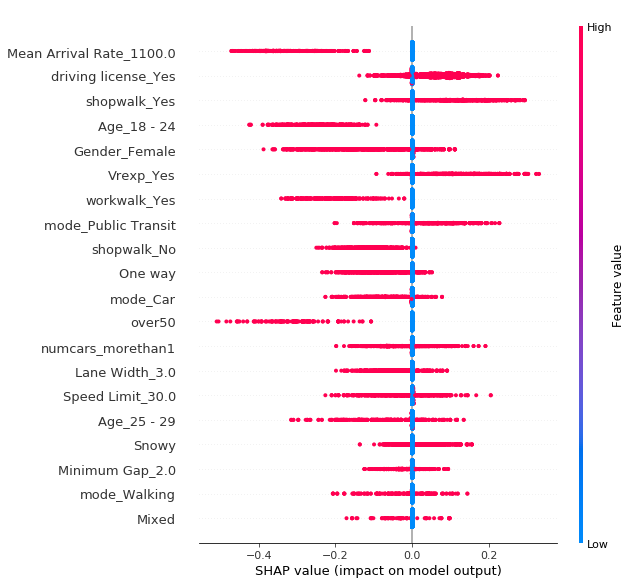

In [218]:
shap.summary_plot(shap_values[0], dfxtrainsub,max_display=32)

In [ ]:
shap.summary_plot(reworkclean.values, features,max_display=32,show=False)

In [ ]:
import matplotlib.pyplot as pl
shap.summary_plot(reworkclean.values, features,max_display=32,show=False)
pl.savefig('shap.png',bbox_inches='tight')


In [ ]:
shap_df=pd.DataFrame(shap_values[0])
shap_df.columns=NCtrain.iloc[:,1:-1].columns

mean=shap_df[shap_df!=0].mean()              #mean of shap values for each feature (non-zeros only

nonzeros=shap_df.astype(bool).sum(axis=0)        #count of non-zeros shap values for each feature

std=shap_df[shap_df!=0].std()                #standard deviation of shap values for each feature

featuresshap=pd.DataFrame()

featuresshap['count1']=nonzeros
featuresshap['bg0mean']=mean                 #bg0: zeros set as background data

featuresshap['bg0std']=std

featuresshap['bg0absmean']=abs(mean)

featuresshap.sort_values(by=['bg0absmean'])

In [ ]:
#using ones as background data
backgrounddata2=pd.DataFrame(np.ones(42)).T         
backgrounddata2.columns=NCtrain.iloc[:,1:-1].columns

explainer2 = shap.KernelExplainer(network.predict_risk,backgrounddata2)
shap_values2 = explainer2.shap_values(dfxtrainsub)





In [ ]:
shap.summary_plot(shap_values2[0], dfxtrainsub,max_display=42)

In [ ]:
shap_values2=pd.DataFrame(shap_values2[0])
shap_values2.columns=NCtrain.iloc[:,1:-1].columns

mean2=shap_values2[shap_values2!=0].mean()              #mean of shap values for each feature (non-zeros only

std2=shap_values2[shap_values2!=0].std()                #standard deviation of shap values for each feature

featuresshap['bg1mean']=mean2                           #bg1: ones set as background data

featuresshap['bg1std']=std2

featuresshap['bg1absmean']=abs(mean2)

In [ ]:
featuresshap











